# Dataset slicing
An event recording is somewhat similar to a video. Sometimes it is desirable to slice a single event recording into multiple samples. During training time, we might want to load just a slice of a recording rather than the whole one. This is typically the case when training an ANN on event frames, if one recording contains multiple labels or if recordings are just very long. We specify a `slicer` method which decides how recordings are cut into smaller chunks. Let's look at how we can cut a sample of the N-MNIST dataset which is around 300 ms into smaller pieces of 50 ms.

In [4]:
import tonic
from tonic import SlicedDataset
from tonic.slicers import SliceByTime

dataset = tonic.datasets.NMNIST(save_to='./data', train=False)

slicing_time_window = 50000 # microseconds
slicer = SliceByTime(time_window=slicing_time_window)
sliced_dataset = SlicedDataset(dataset, slicer=slicer, metadata_path='./metadata/nmnist')

Read metadata from disk.


In [5]:
print(f"Went from {len(dataset)} samples in the original dataset to {len(sliced_dataset)} in the sliced version.")

Went from 10000 samples in the original dataset to 59718 in the sliced version.


In [6]:
events, targets = sliced_dataset[100]

We can verify that the difference between last and first timestamp in the slice is not greater than our slicing time window earlier

In [7]:
slice_time_difference = events["t"][-1] - events["t"][0]
print(f"Difference between last and first timestamp in slice: {slice_time_difference} us")
assert slice_time_difference <= slicing_time_window

Difference between last and first timestamp in slice: 49963 us


## Applying transforms post-slicing
As normally, we can specify transform and/or target_transform which will be applied to the slice after loading.

In [8]:
frame_transform = tonic.transforms.ToImage(sensor_size=tonic.datasets.NMNIST.sensor_size)

sliced_dataset = SlicedDataset(dataset, slicer=slicer, transform=frame_transform, metadata_path='./metadata/nmnist')

Read metadata from disk.


In [9]:
frames, targets = sliced_dataset[100]

We can verify that the sum of events in the frames is the same as the number of events without transform.

In [10]:
print("Number of spikes: " + str(frames.sum()))
assert frames.sum() == len(events)

Number of spikes: 317


## Caching a SlicedDataset
Additionally, we can wrap our newly sliced dataset in a `MemoryCachedDataset`, which will write the slices to working memory. We'll also provide an augmentation transform that is applied post-loading from cache.

In [11]:
import torch
import torchvision
from tonic import MemoryCachedDataset
torch.manual_seed(1234)

augmentation = tonic.transforms.Compose([torch.tensor,
                                         torchvision.transforms.RandomRotation([-45,45])])
augmented_dataset = MemoryCachedDataset(sliced_dataset, transform=augmentation)

In [12]:
rotated_frames, targets = augmented_dataset[200]

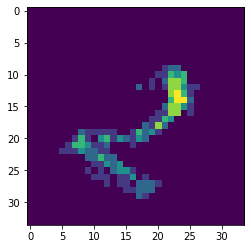

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(rotated_frames[0])